# Importando Bibliotecas

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Funções Auxiliares

In [29]:
def dataFrame_to_boxPlot(dataFrame,var):
    data = {}
    column_value = []
    column_x = []

    for column in range(len(dataFrame.columns)):
        column_value += list(dataFrame.iloc[:,column])
        column_x += [f'x{column+1}' for i in range(len(dataFrame))]

    data[var]=column_value
    data['x']=column_x
    return pd.DataFrame(data)

In [30]:
def describe_var(dataframe,var):
    resultado_var = {}
    
    for periodo in range(len(dataframe.iloc[0,0])):
        aux = []
        for list in dataframe[var]:
            aux.append(list[periodo])
        resultado_var[f'{var}{periodo+1}'] = aux

    return pd.DataFrame(resultado_var)

# Importando Dados

In [31]:
past = 'C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Previsoes/'

In [32]:
previsoes_np = {}
previsoes = []
for index in range(60):
    with open(past+f'Prev_pro/Previsao_pro{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_np['demandas'] = previsoes
previsoes_np = pd.DataFrame(previsoes_np)
previsoes_np.head()


,demandas
0,"[89.08585357666016, 89.50004577636719, 89.8959..."
1,"[89.10758209228516, 89.27462768554688, 89.6483..."
2,"[89.00076293945312, 89.16638946533203, 89.4610..."
3,"[89.05824279785156, 89.42439270019531, 89.7121..."
4,"[89.14275360107422, 89.44071197509766, 89.8783..."


In [33]:
previsoes_ar = {}
previsoes = []
for index in range(60):
    with open(past+f'Prev_ari/Previsao_ari{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_ar['demandas'] = previsoes
previsoes_ar = pd.DataFrame(previsoes_ar)

In [34]:
df_demandas = pd.read_csv('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Demandas_treinamento/demandas')[['date','demandas']]

demandas_treino = df_demandas['demandas']
demandas_treino.head()

0    90
1    89
2    90
3    90
4    92
Name: demandas, dtype: int64

In [35]:
demandas = {}
demandas_aux = []
for i in range(0,int(len(demandas_treino)/52)):
    demandas_aux.append(list(demandas_treino[i*52:(i+1)*52].values))
demandas['demandas'] = demandas_aux
demandas = pd.DataFrame(demandas)

In [36]:
with open('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Prev_teste/test_arima.txt', "r") as arquivo:
	test_ar = [float(demanda) for demanda in arquivo.read().split(',')]

with open('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Prev_teste/test_pro.txt', "r") as arquivo:
	test_np = [float(demanda) for demanda in arquivo.read().split(',')]


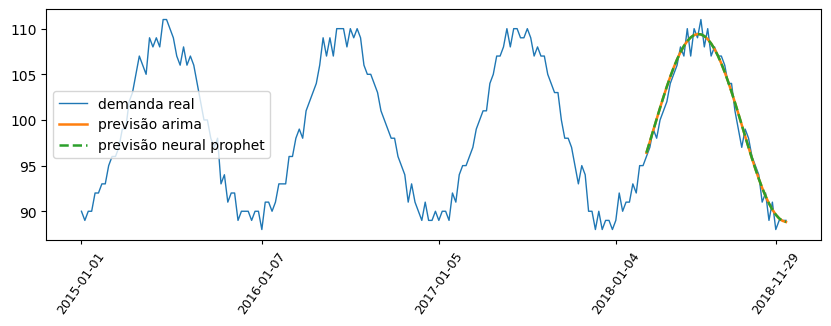

In [37]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,1,1)

plt.plot(df_demandas.date,df_demandas.demandas,label='demanda real', linewidth=1)
plt.plot(df_demandas.date.iloc[166:],test_ar,label='previsão arima', linestyle='-',linewidth=1.8)
plt.plot(df_demandas.date.iloc[166:],test_ar,label='previsão neural prophet',linestyle='--', linewidth=1.8)
plt.xticks([df_demandas.date.values[i] for i in [0,53,105,157,204]])
plt.tick_params(axis='x', labelsize=9, length=3)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.legend()


plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/prev_testes.png', bbox_inches='tight',pad_inches = 0.1,format='png')


# Analise Das Previsões

In [38]:
previsao_demanda_np = describe_var(previsoes_np,'demandas')
previsao_demanda_ar = describe_var(previsoes_ar,'demandas')
demandas_d = describe_var(demandas,'demandas')

In [39]:
boxPlot_previsao_np = dataFrame_to_boxPlot(previsao_demanda_np,'demandas')
boxPlot_previsao_ar = dataFrame_to_boxPlot(previsao_demanda_ar,'demandas')
boxPlot_demandas = dataFrame_to_boxPlot(demandas_d,'demandas')

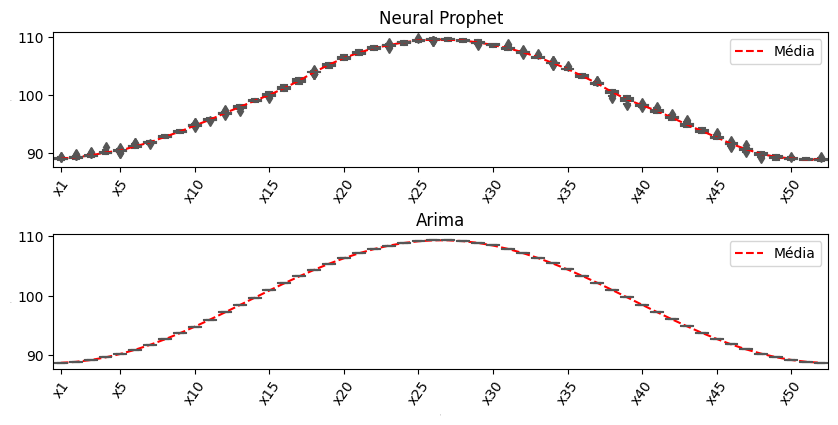

In [40]:
fig=plt.figure(figsize=(10,7))
#fig.suptitle('Distribuição das Previsões de Demandas por Período')



plt.subplots_adjust(wspace=0, hspace=0.5)

ax=fig.add_subplot(3,1,1)
ax.set_title('Neural Prophet')
sns.boxplot(data=boxPlot_previsao_np,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_np.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_np.columns)/5)+1)])
plt.legend()


ax=fig.add_subplot(3,1,2)
ax.set_title('Arima')
sns.boxplot(data=boxPlot_previsao_ar,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_ar.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_ar.columns)/5)+1)])
plt.legend()

'''
ax=fig.add_subplot(3,1,3)
ax.set_title('Demandas Passadas')
sns.boxplot(data=boxPlot_demandas,x='x',y='demandas',color='turquoise')
plt.plot(demandas_d.columns,demandas_d.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(demandas_d.columns)/5)+1)])
plt.legend()
'''

plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/Previsoes.png', format='png', bbox_inches='tight',pad_inches = 0.1)

In [41]:
previsao_demanda_np.head(10)

,demandas1,demandas2,demandas3,demandas4,demandas5,demandas6,demandas7,demandas8,demandas9,demandas10,...,demandas43,demandas44,demandas45,demandas46,demandas47,demandas48,demandas49,demandas50,demandas51,demandas52
0,89.085854,89.500046,89.895950,90.305954,90.396744,90.999458,91.817543,92.765762,93.791252,94.854820,...,95.092361,93.930405,92.960342,91.661911,90.616287,89.743370,89.064095,89.091362,89.000793,88.976791
1,89.107582,89.274628,89.648338,90.141991,90.604599,91.206261,91.979980,92.891052,93.914009,94.956100,...,94.898514,93.752289,92.684456,91.670494,90.810860,90.043350,89.450073,88.992874,88.828957,88.922134
2,89.000763,89.166389,89.461014,89.880501,90.419662,91.072327,91.831291,92.688332,93.634132,94.658264,...,94.637535,93.562462,92.577553,91.694870,90.924515,90.274567,89.751183,89.358688,89.099709,88.975273
3,89.058243,89.424393,89.712112,90.032173,90.671364,91.211975,91.961685,92.829010,94.021378,94.835838,...,95.165466,93.954247,92.556381,91.552391,90.595337,89.925926,89.427032,89.077095,88.864380,88.842682
4,89.142754,89.440712,89.878395,90.108505,90.484009,91.140854,92.026421,92.944382,93.856010,94.841263,...,95.299316,94.090584,92.852661,91.736519,90.747597,89.905357,89.249100,89.061424,88.959023,88.998650
5,89.064972,89.512070,90.039207,90.381615,90.271278,90.921074,91.773636,92.997185,93.702972,94.894829,...,94.999733,93.924385,92.874725,91.900635,90.305351,89.608444,89.241882,89.127846,88.930939,88.846977
6,89.131889,89.423203,89.571213,90.143356,90.478020,91.334274,91.941383,92.928810,93.834244,94.735870,...,94.915878,94.028641,92.901306,91.697212,90.538406,89.591232,89.237617,89.063354,88.982750,89.001266
7,89.170860,89.441254,89.685249,90.134857,90.179329,91.009148,91.886551,92.807922,93.771210,94.775337,...,95.300972,94.185616,93.227272,91.887825,90.912453,89.916420,89.118614,89.202301,89.111877,89.107178
8,88.793678,89.058289,89.383789,89.958939,90.432404,91.339096,92.210213,93.050171,93.831314,94.718842,...,94.963417,93.785469,92.750298,91.727715,90.928497,90.182785,89.597290,89.186531,88.917168,88.785912
9,89.026367,89.282440,89.592430,90.095558,90.658646,91.333443,92.095406,92.928276,93.844193,94.787270,...,95.388695,94.203285,92.961868,91.534081,90.510490,89.752304,89.299362,89.032242,88.895340,88.893784


([<matplotlib.axis.XTick at 0x2627cb9b850>,
 [Text(0, 0, 'x1'),
  Text(4, 0, 'x5'),
  Text(9, 0, 'x10'),
  Text(14, 0, 'x15'),
  Text(19, 0, 'x20'),
  Text(24, 0, 'x25'),
  Text(29, 0, 'x30'),
  Text(34, 0, 'x35'),
  Text(39, 0, 'x40'),
  Text(44, 0, 'x45'),
  Text(49, 0, 'x50')])

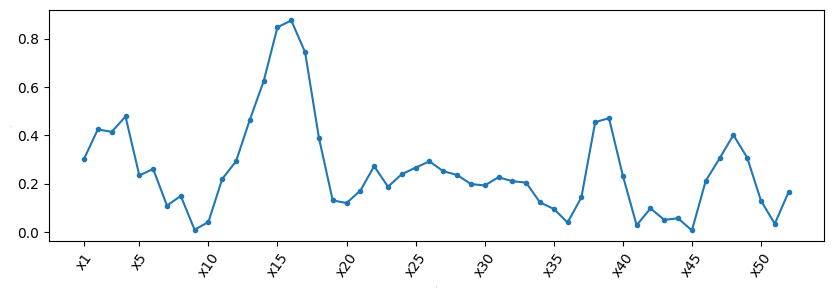

In [52]:
fig=plt.figure(figsize=(10,3))

ax=fig.add_subplot(1,1,1)
plt.plot([f'x{i}' for i in range(1,53)], #x
         abs(previsao_demanda_ar.describe().iloc[1,:]-previsao_demanda_np.describe().iloc[1,:]),  #y
         marker='.')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_np.columns)/5)+1)])
plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/Previsoes.png', format='png', bbox_inches='tight',pad_inches = 0.1)